In [4]:
%load_ext autoreload
%autoreload 2

from datetime import datetime
import pytz

import pandas as pd

from utils.download_data import download_themis_data
from utils.process_data import *
from utils.plot_data import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# base_url = "https://themis.ssl.berkeley.edu/data/themis/tha/l2/esa/2014/"
# start_date = "20140701"
# end_date = "20141231"
# download_dir = "data/tha/esa_july_dec_2014"

# download_themis_data(base_url, start_date, end_date, download_dir)

In [6]:
raw_fgm_matrix = process_fgm("data/tha/fgm_july_dec_2014")
raw_state_matrix = process_state("data/tha/state_july_dec_2014")
raw_eflux_matrix, raw_iflux_matrix = process_sst("data/tha/sst_july_dec_2014")
raw_eplasma_matrix, raw_iplasma_matrix = process_esa("data/tha/esa_july_dec_2014")
raw_omni_matrix = process_omni("data/omni/AE_data_july_dec_2014.txt")

In [7]:
raw_fgm_matrix

,Time,Bx,By,Bz
0,1.404173e+09,32.705685,-4.197578,75.724640
1,1.404173e+09,32.826534,-4.368367,75.815819
2,1.404173e+09,32.873180,-4.286692,75.784416
3,1.404173e+09,32.876461,-4.279731,75.867638
4,1.404173e+09,32.853149,-4.318972,75.883430
...,...,...,...,...
5485874,1.420071e+09,-6.911088,-28.255386,17.682272
5485875,1.420071e+09,-7.056625,-28.222803,17.813412
5485876,1.420071e+09,-7.090713,-28.059710,17.769062
5485877,1.420071e+09,-7.266094,-27.956884,17.787735


In [8]:
raw_state_matrix

,Time,GSM_x,GSM_y,GSM_z
0,1.404173e+09,22266.882812,-40250.328125,-10492.748047
1,1.404173e+09,22285.507812,-40097.554688,-10459.904297
2,1.404173e+09,22303.824219,-39944.253906,-10426.881836
3,1.404173e+09,22321.847656,-39790.398438,-10393.681641
4,1.404173e+09,22339.554688,-39636.011719,-10360.302734
...,...,...,...,...
264955,1.420070e+09,-6421.165039,58677.074219,16498.710938
264956,1.420070e+09,-6498.962891,58760.468750,16498.132812
264957,1.420070e+09,-6576.610840,58843.558594,16497.269531
264958,1.420070e+09,-6654.269531,58926.335938,16496.044922


In [9]:
cutoff_date = datetime(2015, 1, 1, tzinfo=pytz.UTC).timestamp()

In [10]:
interpolated_state = interpolate_columns(raw_state_matrix, raw_fgm_matrix['Time'], ['GSM_x', 'GSM_y', 'GSM_z'])
interpolated_eflux = interpolate_columns(raw_eflux_matrix, raw_fgm_matrix['Time'], ['E_flux_c5'])
interpolated_iflux = interpolate_columns(raw_iflux_matrix, raw_fgm_matrix['Time'], ['I_flux_c5'])
interpolated_eplasma = interpolate_columns(raw_eplasma_matrix, raw_fgm_matrix['Time'], ['E_perp1', 'E_perp2', 'E_perp_avg', 'E_prll', 'E_density', 'E_velocity_xy'])
interpolated_iplasma = interpolate_columns(raw_iplasma_matrix, raw_fgm_matrix['Time'], ['I_perp1', 'I_perp2', 'I_perp_avg', 'I_prll', 'I_density', 'I_velocity_xy'])
interpolated_omni = interpolate_columns(raw_omni_matrix, raw_fgm_matrix['Time'], ['AE'])

interpolated_data = {**interpolated_state, **interpolated_eflux, **interpolated_iflux, **interpolated_eplasma, **interpolated_iplasma, **interpolated_omni}

final_matrix = pd.concat([raw_fgm_matrix.reset_index(drop=True), pd.DataFrame(interpolated_data)], axis=1)

final_matrix.insert(1, 'Epoch_time', final_matrix['Time'].copy())
final_matrix = final_matrix[final_matrix['Epoch_time'] < cutoff_date]
final_matrix['Time'] = pd.to_datetime(final_matrix['Time'], unit='s', utc=True)

In [11]:
final_matrix['dBz6sec'] = final_matrix['Bz'].shift(-1) - final_matrix['Bz'].shift(1)
final_matrix['dFe'] = final_matrix['E_flux_c5'].shift(-1) - final_matrix['E_flux_c5'].shift(1)
final_matrix['dFi'] = final_matrix['I_flux_c5'].shift(-1) - final_matrix['I_flux_c5'].shift(1)

final_matrix['rel_dFe'] = final_matrix['dFe'] / ((final_matrix['E_flux_c5'].shift(-1) + final_matrix['E_flux_c5'].shift(1)) / 2)
final_matrix['rel_dFi'] = final_matrix['dFi'] / ((final_matrix['I_flux_c5'].shift(-1) + final_matrix['I_flux_c5'].shift(1)) / 2)

final_matrix['temp_e_Ae'] = (final_matrix['E_perp_avg'] / final_matrix['E_prll']) - 1
final_matrix['temp_i_Ae'] = (final_matrix['I_perp_avg'] / final_matrix['I_prll']) - 1

In [12]:
final_matrix

,Time,Epoch_time,Bx,By,Bz,GSM_x,GSM_y,GSM_z,E_flux_c5,I_flux_c5,...,I_density,I_velocity_xy,AE,dBz6sec,dFe,dFi,rel_dFe,rel_dFi,temp_e_Ae,temp_i_Ae
0,2014-07-01 00:04:29.472872972+00:00,1.404173e+09,32.705685,-4.197578,75.724640,22348.100094,-39559.904164,-10343.821143,328731.479708,8875.974443,...,1.295257,5.175796,63.775439,NaN,NaN,NaN,NaN,NaN,0.615356,0.392873
1,2014-07-01 00:04:32.399597168+00:00,1.404173e+09,32.826534,-4.368367,75.815819,22348.948672,-39552.346509,-10342.184483,335691.095578,8814.399717,...,1.296800,5.232403,63.773000,0.059776,7328.265944,-965.225459,0.022047,-0.114999,0.627130,0.393841
2,2014-07-01 00:04:35.326321602+00:00,1.404173e+09,32.873180,-4.286692,75.784416,22349.797251,-39544.788853,-10340.547823,336059.745652,7910.748983,...,1.298343,5.289011,63.770561,0.051819,-5725.912978,-1593.786628,-0.017204,-0.198788,0.647327,0.394814
3,2014-07-01 00:04:38.253045797+00:00,1.404173e+09,32.876461,-4.279731,75.867638,22350.645829,-39537.231197,-10338.911163,329965.182600,7220.613089,...,1.299886,5.345618,63.768122,0.099014,-3021.129061,-220.824705,-0.009030,-0.028310,0.661426,0.395790
4,2014-07-01 00:04:41.179769993+00:00,1.404173e+09,32.853149,-4.318972,75.883430,22351.494408,-39529.673542,-10337.274503,333038.616591,7689.924279,...,1.301429,5.402225,63.765684,-0.051598,3473.702134,1342.427752,0.010472,0.170104,0.663943,0.396772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5485783,2014-12-31 23:59:48.034995794+00:00,1.420070e+09,-7.329637,-27.916031,16.939493,-6794.074975,59074.862956,16493.217443,17794.830067,701.760582,...,0.344687,11.451656,7.093061,-0.075235,-275.043396,-1.080079,-0.015456,-0.001539,0.059207,0.221727
5485784,2014-12-31 23:59:50.922860622+00:00,1.420070e+09,-7.302068,-27.800406,16.913635,-6797.812090,59078.833206,16493.141863,17657.308143,701.220542,...,0.344622,11.498552,7.070600,-0.039831,-275.043396,-1.080079,-0.015577,-0.001540,0.059799,0.222124
5485785,2014-12-31 23:59:53.810715914+00:00,1.420070e+09,-7.240098,-27.833035,16.899662,-6801.549193,59082.803443,16493.066282,17519.786672,700.680504,...,0.344556,11.545448,7.048139,0.056929,-275.042941,-1.080077,-0.015699,-0.001541,0.060393,0.222521
5485786,2014-12-31 23:59:56.698571205+00:00,1.420070e+09,-7.247959,-27.618179,16.970564,-6805.286296,59086.773680,16492.990701,17382.265201,700.140465,...,0.344490,11.592344,7.025678,0.104691,-275.043407,-1.080079,-0.015823,-0.001543,0.060986,0.222917


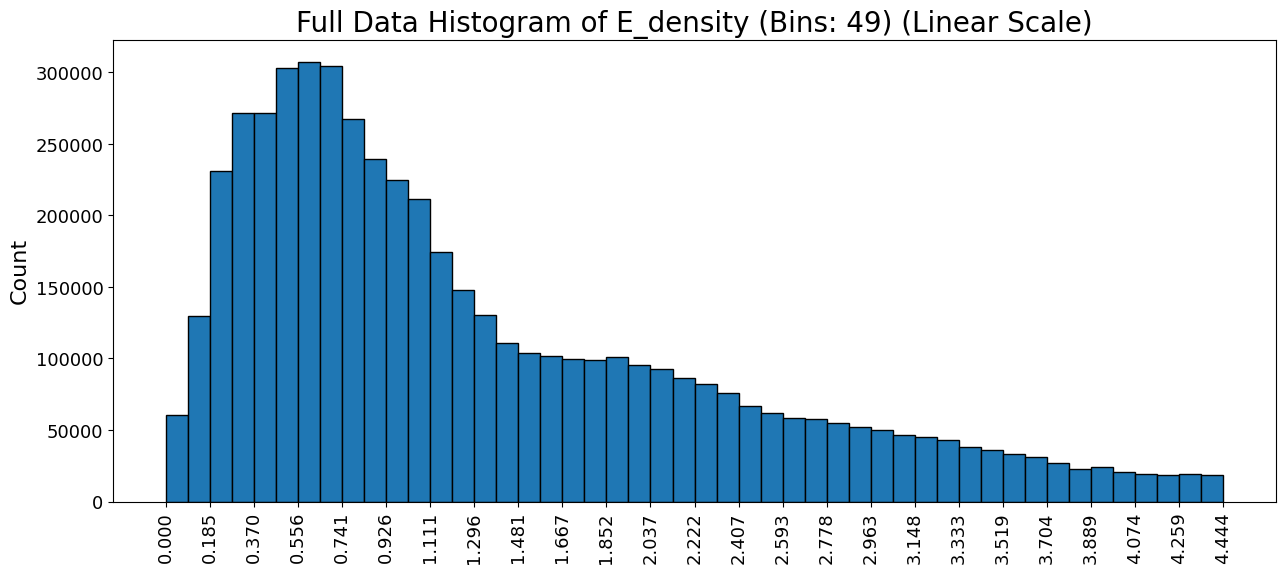

In [13]:
plot_histogram(dataframe=final_matrix, column='E_density', filter_column='E_density', remove_outliers=True)

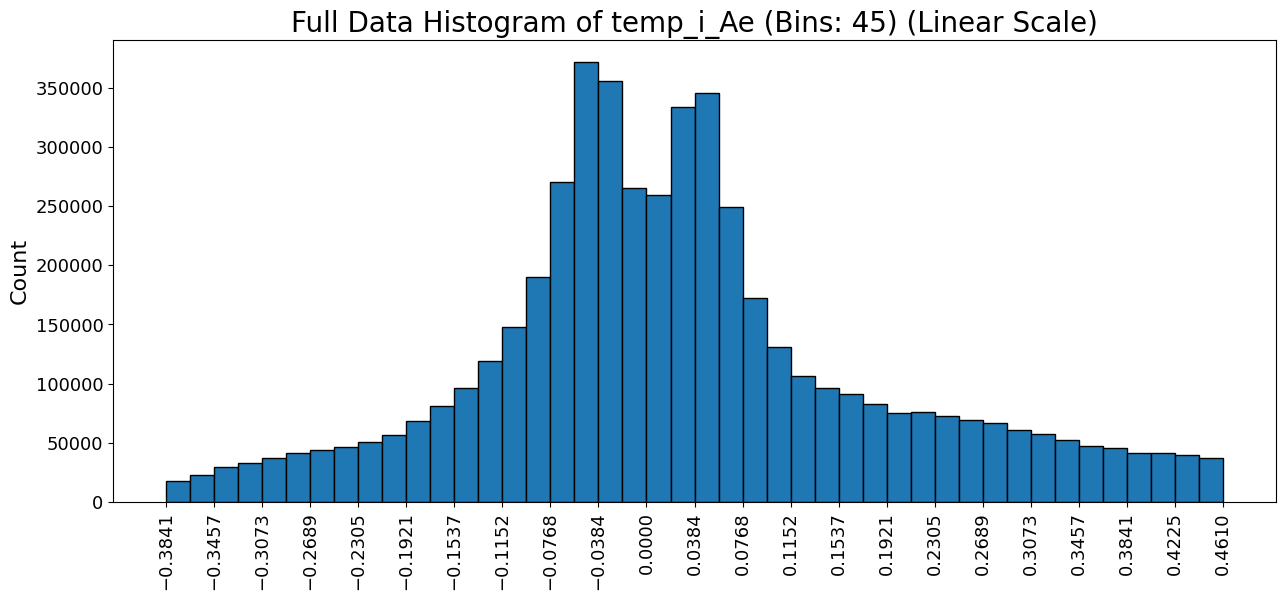

In [14]:
plot_histogram(dataframe=final_matrix, column='temp_i_Ae', filter_column='temp_i_Ae', remove_outliers=True)

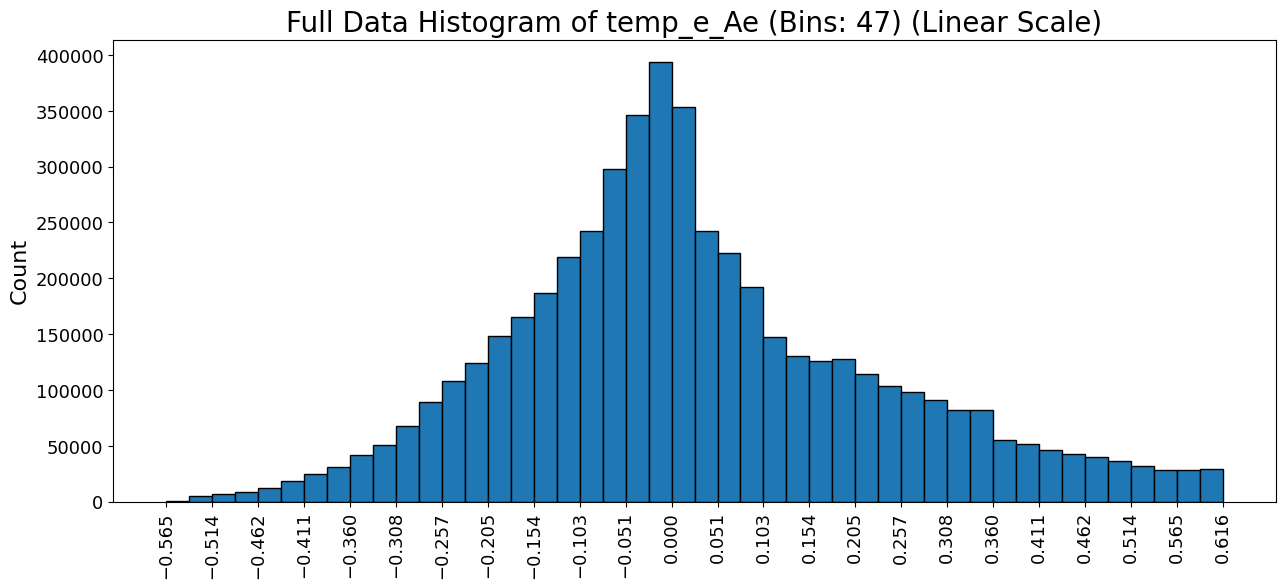

In [15]:
plot_histogram(dataframe=final_matrix, column='temp_e_Ae', filter_column='temp_e_Ae', remove_outliers=True)

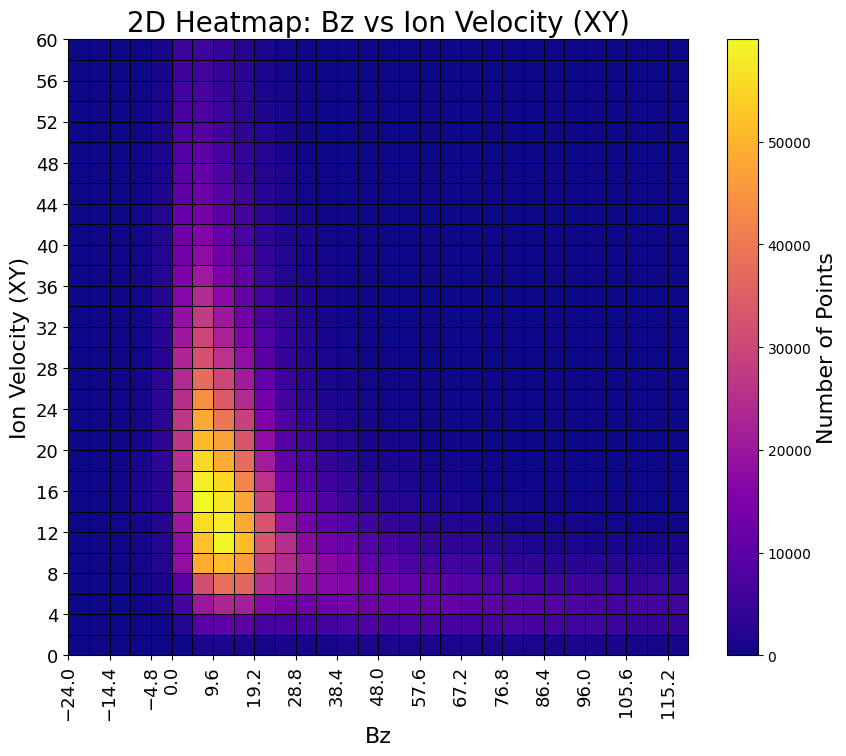

In [16]:
plot_2d_histogram(
    dataframe=final_matrix,
    q1='Bz',
    q2='I_velocity_xy',
    remove_outliers=True,
    xlab='Bz',
    ylab='Ion Velocity (XY)', 
    bins=30,
    dpi=100,
    xlim=(-24, 120),
    ylim=(0, 60)
)

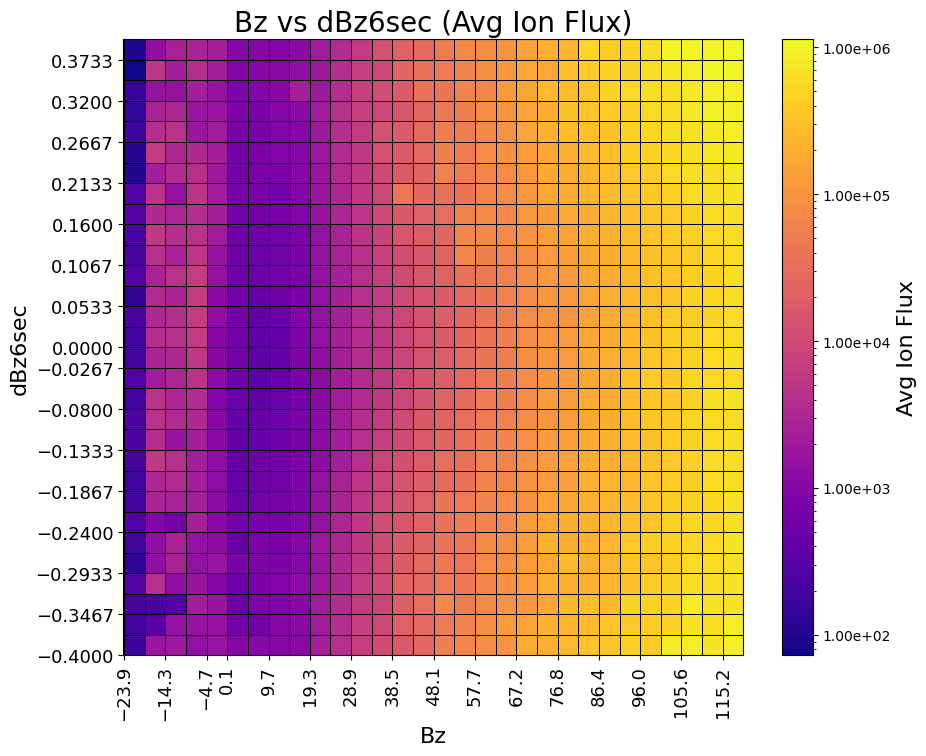

In [17]:
plot_2d_avg_histogram(
    dataframe=final_matrix,
    q1='Bz',
    q2='dBz6sec',
    q3='I_flux_c5',
    xlab='Bz',
    ylab='dBz6sec',
    clab='Avg Ion Flux',
    log_scale=True,
    xlim=(-24, 120),
    ylim=(-0.4, 0.4)
)

In [18]:
final_matrix

,Time,Epoch_time,Bx,By,Bz,GSM_x,GSM_y,GSM_z,E_flux_c5,I_flux_c5,...,I_density,I_velocity_xy,AE,dBz6sec,dFe,dFi,rel_dFe,rel_dFi,temp_e_Ae,temp_i_Ae
0,2014-07-01 00:04:29.472872972+00:00,1.404173e+09,32.705685,-4.197578,75.724640,22348.100094,-39559.904164,-10343.821143,328731.479708,8875.974443,...,1.295257,5.175796,63.775439,NaN,NaN,NaN,NaN,NaN,0.615356,0.392873
1,2014-07-01 00:04:32.399597168+00:00,1.404173e+09,32.826534,-4.368367,75.815819,22348.948672,-39552.346509,-10342.184483,335691.095578,8814.399717,...,1.296800,5.232403,63.773000,0.059776,7328.265944,-965.225459,0.022047,-0.114999,0.627130,0.393841
2,2014-07-01 00:04:35.326321602+00:00,1.404173e+09,32.873180,-4.286692,75.784416,22349.797251,-39544.788853,-10340.547823,336059.745652,7910.748983,...,1.298343,5.289011,63.770561,0.051819,-5725.912978,-1593.786628,-0.017204,-0.198788,0.647327,0.394814
3,2014-07-01 00:04:38.253045797+00:00,1.404173e+09,32.876461,-4.279731,75.867638,22350.645829,-39537.231197,-10338.911163,329965.182600,7220.613089,...,1.299886,5.345618,63.768122,0.099014,-3021.129061,-220.824705,-0.009030,-0.028310,0.661426,0.395790
4,2014-07-01 00:04:41.179769993+00:00,1.404173e+09,32.853149,-4.318972,75.883430,22351.494408,-39529.673542,-10337.274503,333038.616591,7689.924279,...,1.301429,5.402225,63.765684,-0.051598,3473.702134,1342.427752,0.010472,0.170104,0.663943,0.396772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5485783,2014-12-31 23:59:48.034995794+00:00,1.420070e+09,-7.329637,-27.916031,16.939493,-6794.074975,59074.862956,16493.217443,17794.830067,701.760582,...,0.344687,11.451656,7.093061,-0.075235,-275.043396,-1.080079,-0.015456,-0.001539,0.059207,0.221727
5485784,2014-12-31 23:59:50.922860622+00:00,1.420070e+09,-7.302068,-27.800406,16.913635,-6797.812090,59078.833206,16493.141863,17657.308143,701.220542,...,0.344622,11.498552,7.070600,-0.039831,-275.043396,-1.080079,-0.015577,-0.001540,0.059799,0.222124
5485785,2014-12-31 23:59:53.810715914+00:00,1.420070e+09,-7.240098,-27.833035,16.899662,-6801.549193,59082.803443,16493.066282,17519.786672,700.680504,...,0.344556,11.545448,7.048139,0.056929,-275.042941,-1.080077,-0.015699,-0.001541,0.060393,0.222521
5485786,2014-12-31 23:59:56.698571205+00:00,1.420070e+09,-7.247959,-27.618179,16.970564,-6805.286296,59086.773680,16492.990701,17382.265201,700.140465,...,0.344490,11.592344,7.025678,0.104691,-275.043407,-1.080079,-0.015823,-0.001543,0.060986,0.222917


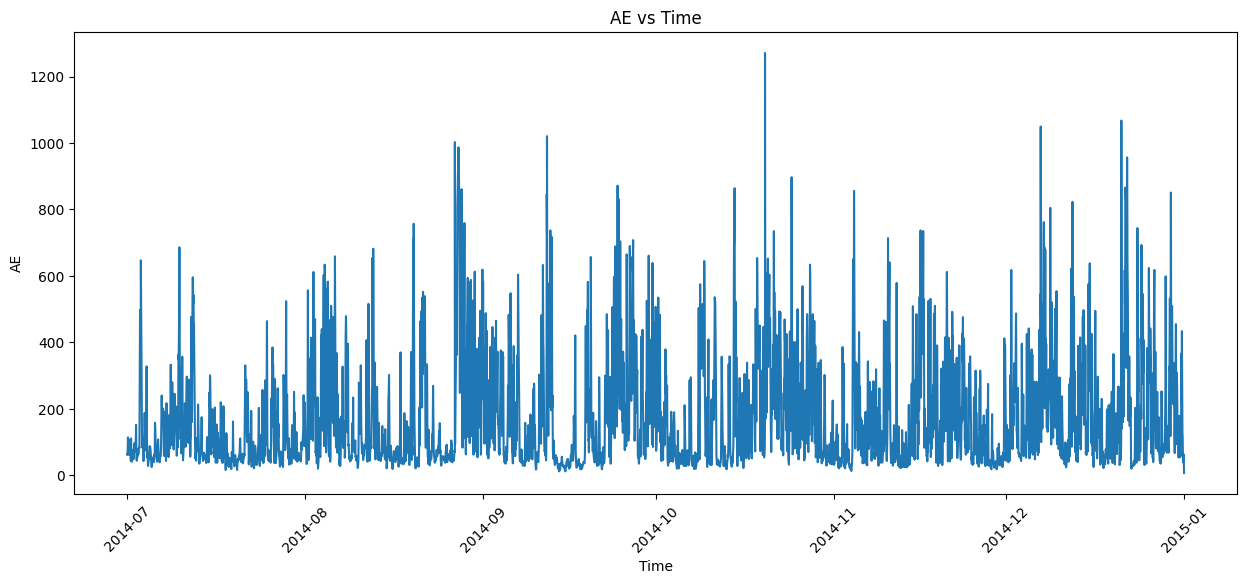

In [19]:
plot_time_series(final_matrix, 'AE')

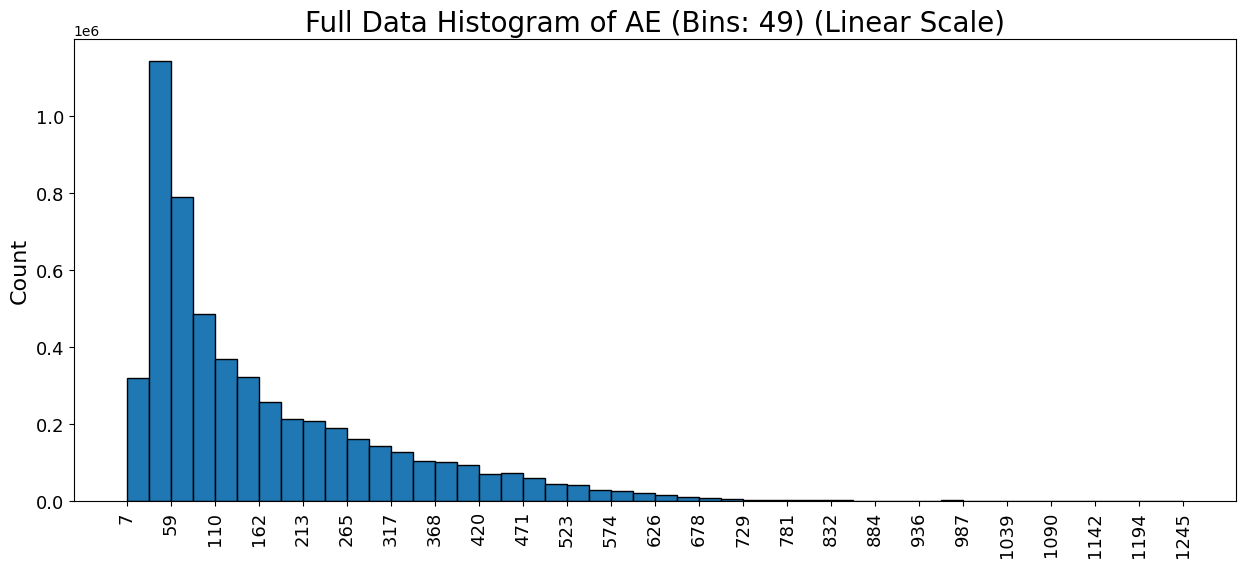

In [20]:
plot_histogram(final_matrix, column='AE')